## 0. Getting setup

In [2]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")

torch version: 2.2.2
torchvision version: 0.17.2


In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print(f"[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular import data_setup, engine
except:
    print("[INFO] Couldn't find going_modular script")
try:
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    print(f"[INFO] Couldn't find helper_functions")

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1.Get Data

In [5]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

In [7]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f"Manualy created transforms: {manual_transforms}")

Manualy created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [8]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78bc55e987d0>,
 ['pizza', 'steak', 'sushi'])

In [8]:
image_batch, label_batch =  next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

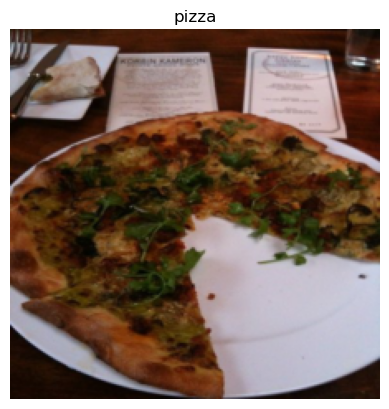

In [9]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [10]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height*width) / patch_size**2)
print(f"NUmber of patches (N) with image height (H={height}), width (W={width}) and patch_size (P={patch_size})")

NUmber of patches (N) with image height (H=224), width (W=224) and patch_size (P=16)


* Input: The image starts as 2D with H x W x C
* Output: The image gets converted to a sequence of fllatened 2D patches with size N x (P^2 * C)

In [11]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (singel 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (singel 2D image flattened into patches): (196, 768)


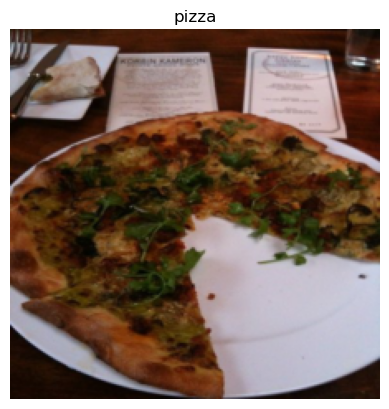

In [12]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

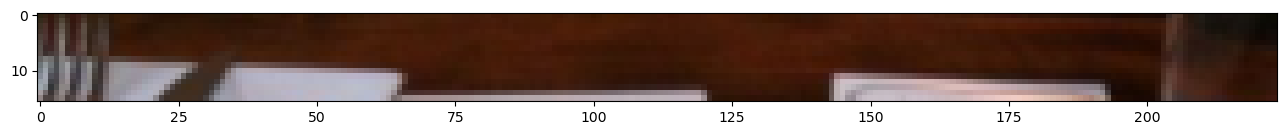

In [13]:
image_permuted = image.permute(1, 2, 0)

plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


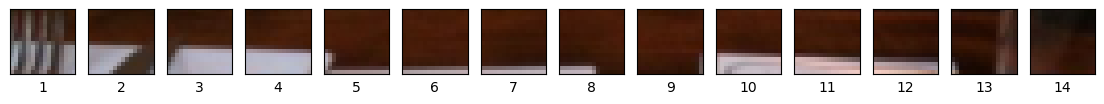

In [14]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=1,
                       ncols=img_size//patch_size,
                       figsize=(num_patches, num_patches),
                       sharex=True,
                       sharey=True)

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0
Number of patches per column: 14.0
Total patches: 196.0
Patch size: 16 pixels x 16 pixels


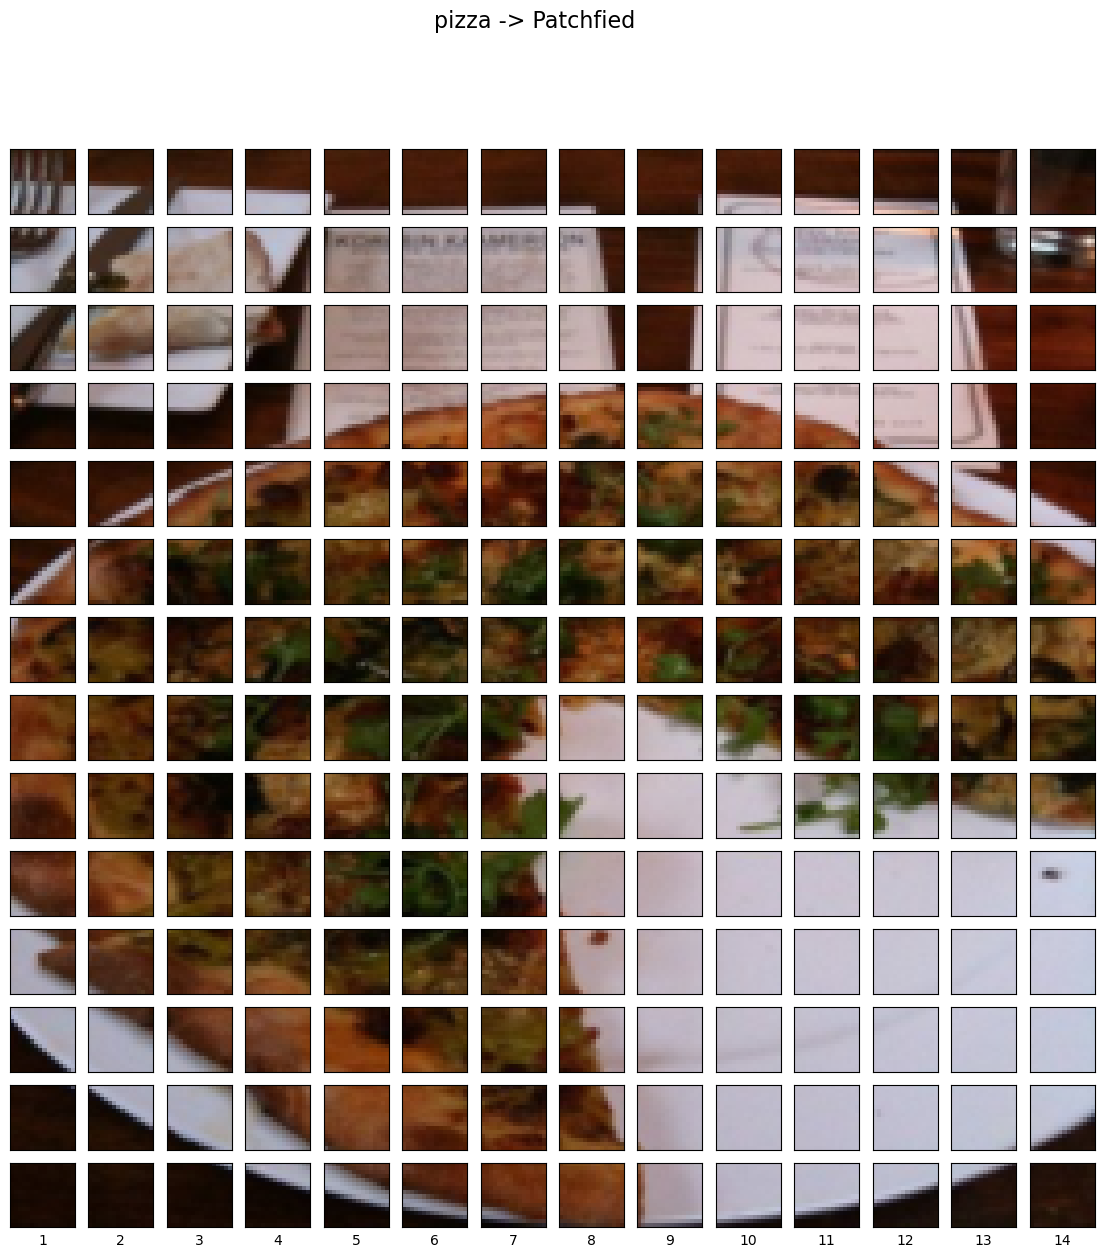

In [15]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0
print(f"Number of patches per row: {num_patches}\
\nNumber of patches per column: {num_patches}\
\nTotal patches: {num_patches*num_patches}\
\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        # Plot the permuted image patch (image_permuted -> (H, W, C)
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                         patch_width:patch_width+patch_size:])
        # Set up information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

fig.suptitle(f"{class_names[label]} -> Patchfied", fontsize=16)
plt.show()

In [16]:
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

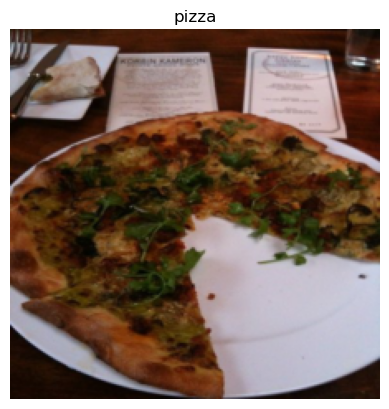

In [17]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [18]:
image_out_of_conv = conv2d(image.unsqueeze(0))  # add a singel batch dim
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [55, 707, 306, 46, 139]


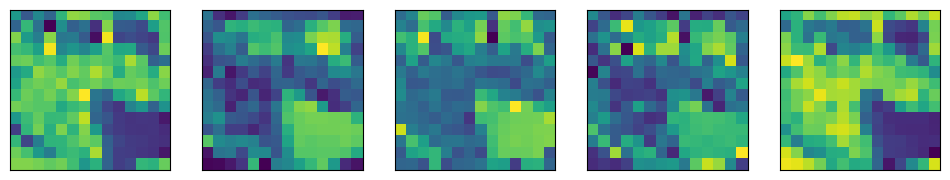

In [19]:
# PLot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 768), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [20]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.0342, -0.0737,  0.0452,  0.0250,  0.0845,  0.0937,  0.0969,
            0.0799, -0.0076,  0.1109,  0.1280,  0.1196, -0.0349, -0.0309],
          [-0.0258, -0.0017, -0.0329, -0.1484, -0.0963, -0.0524, -0.0561,
            0.0066, -0.0911, -0.0401, -0.0205, -0.0418, -0.0560, -0.0225],
          [ 0.0980,  0.0429,  0.0410, -0.0746, -0.0381, -0.0320, -0.0336,
            0.0922, -0.0810,  0.0094, -0.0240, -0.0261, -0.1482, -0.0468],
          [-0.0529, -0.1339, -0.1029, -0.0606, -0.0982, -0.1461, -0.1618,
           -0.0886, -0.0161, -0.2263, -0.0438, -0.0209,  0.0597, -0.0118],
          [-0.0333,  0.0105, -0.0473, -0.0652, -0.0179, -0.0579, -0.0153,
            0.0507, -0.0618, -0.0200,  0.0051, -0.1250,  0.0748,  0.0094],
          [ 0.0621, -0.0487, -0.0063, -0.0457, -0.0182,  0.0059, -0.0010,
           -0.0249,  0.0446, -0.0250, -0.0285, -0.0159,  0.1606, -0.1497],
          [-0.0271, -0.0274,  0.0284,  0.0301,  0.0313, -0.0589, -0.0483,
            0.0357, -0.0302,  0.

In [21]:
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [22]:
flatten = nn.Flatten(start_dim=2, end_dim=3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flatten image feature map shape: torch.Size([1, 768, 196])


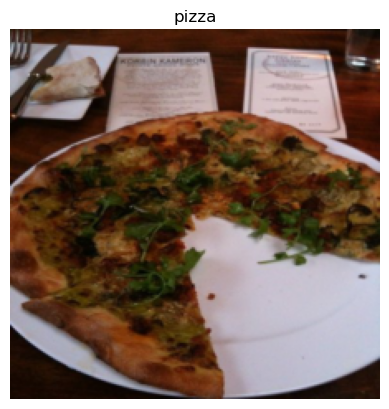

In [23]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))  # add batch dim to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# Flatetn the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flatten image feature map shape: {image_out_of_conv_flattened.shape}")

In [24]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape}")

Patch embedding sequence shape: torch.Size([1, 196, 768])


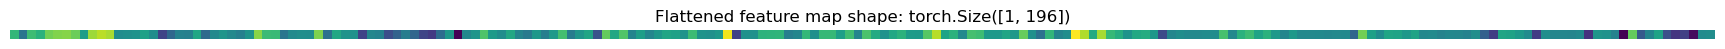

In [25]:
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0]

plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [26]:
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[ 0.0342, -0.0737,  0.0452,  0.0250,  0.0845,  0.0937,  0.0969,  0.0799,
          -0.0076,  0.1109,  0.1280,  0.1196, -0.0349, -0.0309, -0.0258, -0.0017,
          -0.0329, -0.1484, -0.0963, -0.0524, -0.0561,  0.0066, -0.0911, -0.0401,
          -0.0205, -0.0418, -0.0560, -0.0225,  0.0980,  0.0429,  0.0410, -0.0746,
          -0.0381, -0.0320, -0.0336,  0.0922, -0.0810,  0.0094, -0.0240, -0.0261,
          -0.1482, -0.0468, -0.0529, -0.1339, -0.1029, -0.0606, -0.0982, -0.1461,
          -0.1618, -0.0886, -0.0161, -0.2263, -0.0438, -0.0209,  0.0597, -0.0118,
          -0.0333,  0.0105, -0.0473, -0.0652, -0.0179, -0.0579, -0.0153,  0.0507,
          -0.0618, -0.0200,  0.0051, -0.1250,  0.0748,  0.0094,  0.0621, -0.0487,
          -0.0063, -0.0457, -0.0182,  0.0059, -0.0010, -0.0249,  0.0446, -0.0250,
          -0.0285, -0.0159,  0.1606, -0.1497, -0.0271, -0.0274,  0.0284,  0.0301,
           0.0313, -0.0589, -0.0483,  0.0357, -0.0302,  0.0384,  0.0374, -0.0041,
           0.047

In [9]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input iamge into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defeault to 3
        patch_size (int): Size of patches to convert input image into. Default to 16.
        embedding_dim (int): Size of embedding to turn image into. Default to 768.
    """
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # Create a layer  to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                out_channels=embedding_dim,
                                kernel_size=patch_size,
                                stride=patch_size,
                                padding=0)
        
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch_size, image shape: {image_resolution}.\
        patch_size: {patch_size}"

        x_patched = self.patcher(x)
        x_flatten = self.flatten(x_patched)
        return x_flatten.permute(0, 2, 1)  # [batch_size, N, P^2*C]

In [28]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                           patch_size=16,
                           embedding_dim=768)

print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [29]:
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250)  # will error  because image size is incompatible with patch_size

# summary(PatchEmbedding(),
#         input_size=random_input_image,
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [30]:
print(patch_embedded_image)
print(f"Patch embedded_shape: {patch_embedded_image.shape}")

tensor([[[-0.4540,  0.0046, -0.1580,  ...,  0.2369, -0.0273,  0.3145],
         [-0.1385, -0.0677, -0.2877,  ...,  0.1832,  0.0860,  0.2458],
         [-0.2635,  0.0679, -0.3791,  ...,  0.4114,  0.0459,  0.1031],
         ...,
         [-0.5227,  0.1839,  0.3010,  ...,  0.2607, -0.4772,  0.0552],
         [-0.0066, -0.1253, -0.0041,  ...,  0.2421, -0.3258,  0.0482],
         [-0.1226, -0.0038, -0.0430,  ...,  0.0706, -0.0444,  0.0555]]],
       grad_fn=<PermuteBackward0>)
Patch embedded_shape: torch.Size([1, 196, 768])


In [31]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)

print(class_token[:, :, :10])

print(f"Class token shape: {class_token.shape}")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768])


In [32]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1)

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape}")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.4540,  0.0046, -0.1580,  ...,  0.2369, -0.0273,  0.3145],
         [-0.1385, -0.0677, -0.2877,  ...,  0.1832,  0.0860,  0.2458],
         ...,
         [-0.5227,  0.1839,  0.3010,  ...,  0.2607, -0.4772,  0.0552],
         [-0.0066, -0.1253, -0.0041,  ...,  0.2421, -0.3258,  0.0482],
         [-0.1226, -0.0038, -0.0430,  ...,  0.0706, -0.0444,  0.0555]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768])


In [33]:
number_of_patches = int((height*width) / patch_size**2)
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)
print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape}")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768])


In [34]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.5460, 1.0046, 0.8420,  ..., 1.2369, 0.9727, 1.3145],
         [0.8615, 0.9323, 0.7123,  ..., 1.1832, 1.0860, 1.2458],
         ...,
         [0.4773, 1.1839, 1.3010,  ..., 1.2607, 0.5228, 1.0552],
         [0.9934, 0.8747, 0.9959,  ..., 1.2421, 0.6742, 1.0482],
         [0.8774, 0.9962, 0.9570,  ..., 1.0706, 0.9556, 1.0555]]],
       grad_fn=<AddBackward0>)


In [35]:
set_seeds()

patch_size = 16

print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# Get image tensor and batch dimension
x = image.unsqueeze(0)

patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

number_of_patches = int((height*width) / patch_size**2)
postion_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                 requires_grad=True)

patch_add_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_add_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Equation 2: Multi-Head Attention (MSA)

In [10]:

# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [37]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


In [16]:
class MLPBlock(nn.Module):
    def __init__(
            self,
            embedding_dim:int=768,
            mlp_size:int=3072,
            dropout:float=0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                    out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                    out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [39]:
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


In [11]:
class TransformerEncoderBlock(nn.Module):
    def __init__(
        self,
        embedding_dim:int=768,
        num_heads:int=12,
        mlp_size:int=3078,
        mlp_dropout:float=0.1,
        attn_dropout:float=0):
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                  mlp_size=mlp_size,
                                  dropout=mlp_dropout)

    def forward(self, x):
        # Create residual connection for MSA block
        x = self.msa_block(x) + x
        # Create residual connection for MLP block
        x = self.mlp_block(x) + x
        return x

In [41]:
transformer_encoder_block = TransformerEncoderBlock()

# summary(model=transformer_encoder_block,
#         input_size=(1, 197, 768),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [42]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3078,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3078, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3078, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [22]:
patch_size = 16

In [23]:
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12, 
                 attn_dropout:float=0,
                 mlp_dropout:float=0.1,
                 embedding_dropout:float=0.1,
                 num_classes:int=1000):
        super().__init__()
       
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
       
        self.num_patches = (img_size * img_size) // patch_size**2
       
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True) 
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
        
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
 
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

       
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )


    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)
        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)
        x = self.position_embedding + x
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])  # run on each sample in a batch at 0 index
        return x

In [24]:
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768))
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1)

print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [25]:
set_seeds()

random_image_tensor = torch.randn(1, 3, 224, 224)
vit = ViT(num_classes=len(class_names))
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [26]:
from torchinfo import summary

# summary(model=vit,
#         input_size=(32, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [28]:
import torch

def print_gpu_memory():
    device = torch.cuda.current_device()
    allocated = torch.cuda.memory_allocated(device) / 1024**2
    total = torch.cuda.get_device_properties(device).total_memory / 1024**2
    usage = (allocated / total) * 100
    print(f"Gpu Memory Usage: Allocated: {allocated:.2f} MiB, Total {total:.2f} MiB, Usage: {usage:.2f}")

print_gpu_memory()

Gpu Memory Usage: Allocated: 0.00 MiB, Total 8110.94 MiB, Usage: 0.00


In [30]:
from going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.1948 | train_acc: 0.3633 | test_loss: 5.1218 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.9518 | train_acc: 0.3320 | test_loss: 1.6203 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2073 | train_acc: 0.4570 | test_loss: 1.7584 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2482 | train_acc: 0.2969 | test_loss: 1.3214 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1331 | train_acc: 0.4297 | test_loss: 1.2293 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1787 | train_acc: 0.3125 | test_loss: 1.2244 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2512 | train_acc: 0.2578 | test_loss: 1.2060 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1147 | train_acc: 0.4258 | test_loss: 1.1859 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1458 | train_acc: 0.3047 | test_loss: 1.0135 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2647 | train_acc: 0.2617 | test_loss: 1.3921 | test_acc: 0.2604


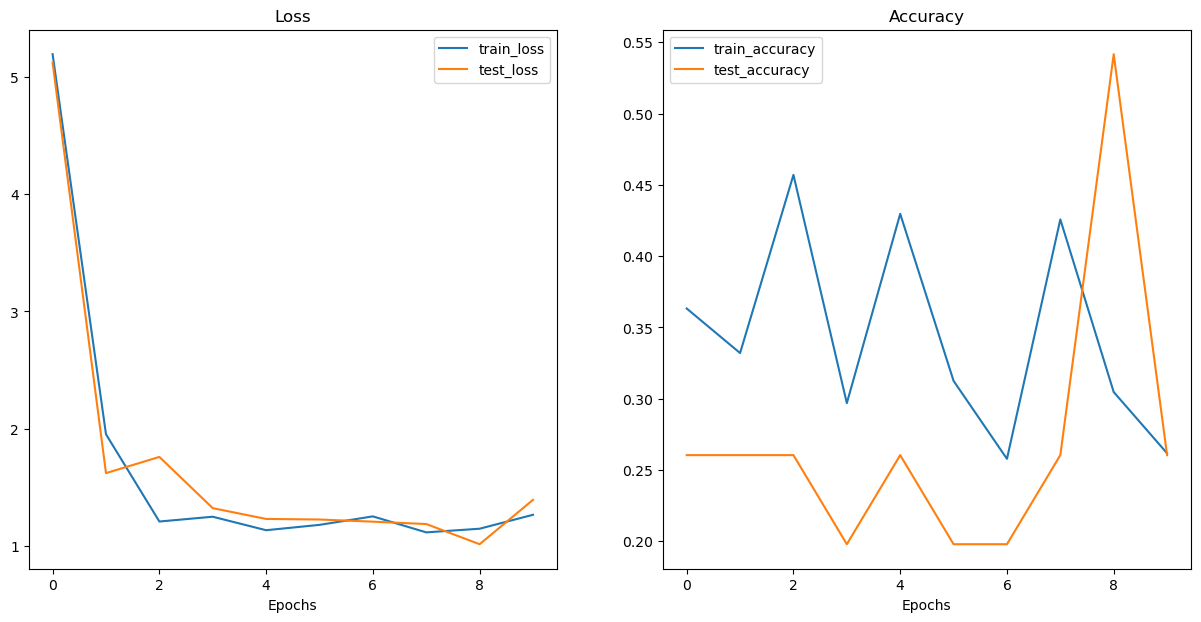

In [32]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

In [34]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.2.2
0.17.2


In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [37]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit

In [39]:
# summary(model=pretrained_vit,
#         input_size=(32, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
#        )

In [40]:
from helper_functions import download_data

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [41]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [42]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [45]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=pretrained_vit_transforms,
    batch_size=32)

In [50]:
from going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
criterium = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=criterium,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7665 | train_acc: 0.7227 | test_loss: 0.5432 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.3428 | train_acc: 0.9453 | test_loss: 0.3263 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2064 | train_acc: 0.9531 | test_loss: 0.2707 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.1556 | train_acc: 0.9570 | test_loss: 0.2422 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.1246 | train_acc: 0.9727 | test_loss: 0.2279 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1216 | train_acc: 0.9766 | test_loss: 0.2129 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0938 | train_acc: 0.9766 | test_loss: 0.2352 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0797 | train_acc: 0.9844 | test_loss: 0.2281 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.1098 | train_acc: 0.9883 | test_loss: 0.2074 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0650 | train_acc: 0.9883 | test_loss: 0.1804 | test_acc: 0.9176


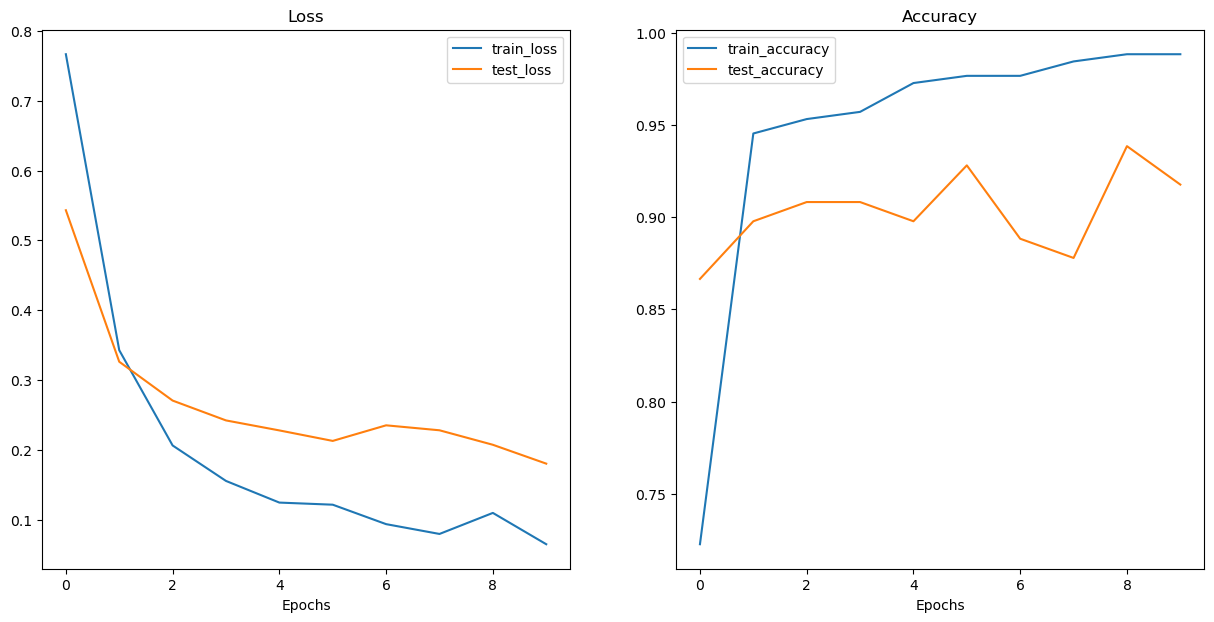

In [51]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [52]:
from going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [53]:
from pathlib import Path

pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In [86]:
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from typing import List, Tuple, Optional

from PIL import Image


def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: Optional[torchvision.transforms] = None,
    device: torch.device = device,
):

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0).to(device)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image)

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label.item()]} | Prob: {target_image_pred_probs.max().item():.3f}"
    )
    plt.axis(False)

data/pizza_steak_sushi/04-pizza-dad.jpeg already exists, skipping download.


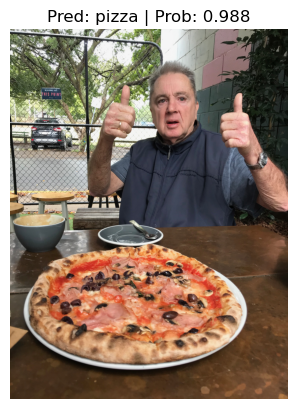

In [87]:
import requests

# Import function to make predictions on images and plot them
# from going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_namesc